Import libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

from import_data import load_data

Import data

In [3]:
listVideo = load_data('../data_luc/video/')

nbVideos = len(listVideo)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

   configurationID  H264  no_8x8dct  no_asm  no_cabac  no_deblock  \
0                1  True       True   False     False        True   
1               10  True       True   False      True       False   
2              100  True       True   False     False        True   
3             1000  True       True   False      True       False   
4             1001  True      False   False     False        True   

   no_fast_pskip  no_mbtree  no_mixed_refs  no_weightb  rc_lookahead  ref  \
0           True      False           True        True            20    9   
1           True      False          False        True            40    9   
2          False       True           True       False            40    1   
3           True       True           True       False            40    9   
4          False      False           True       False            60    5   

      size  usertime  systemtime  elapsedtime  
0  1718492   22.9416      0.2784       3.1876  
1  1962957   26.8176      

## 2) Full transfer

##### MS function

In [9]:
def full_transfer(source_id, target_id, nb_config_target_training, predictedVar, shift_function):
    
    # the percentage (proportion) of configurations used for the test
    pct_test = 1-nb_config_target_training/listVideo[target_id].size
    
    # random state , i.e. a seed to split the source and the target datasets
    # by using the same set of configurations for training and testing
    random_state = np.random.randint(0,1000)
    
    # We define the source video, and split it into train-test
    source = listVideo[source_id]
    y_src = np.array(source[predictedVar], dtype=float)
    y_src_train, y_src_test = train_test_split(y_src, test_size=pct_test, random_state=random_state)
    
    # We define the target video, and split it into train-test
    target = listVideo[target_id]
    y_tgt = np.array(target[predictedVar], dtype=float)
    y_tgt_train, y_tgt_test = train_test_split(y_tgt, test_size=pct_test, random_state=random_state)
    
    # The shift function, to transfer the prediction from the source to the target
    shift = shift_function()
    shift.fit(np.array(y_src_train).reshape(-1,1), y_tgt_train)
    y_tgt_pred_test = shift.predict(y_src_test.reshape(-1,1))
    
    # We return the mean average percentage error 
    # between the real values of y_test from target 
    # and the predictions shifted 
    return min(mape(y_tgt_test, y_tgt_pred_test),1)


# run test
full_transfer(source_id = 1,
            target_id = 2,
            predictedVar = 'elapsedtime',
            shift_function = LinearRegression,
            nb_config_target_training = 32)

0.07955814083788006

#### Test it for different videos, and nb_config

In [13]:
predictedVar = 'elapsedtime'
nb_config = [16, 32, 64, 128, 256, 320, 448, 640, 960]
shift_function = RandomForestRegressor

res_full_transfer = pd.DataFrame({'id_video' : range(nbVideos)})

for conf in nb_config:

    mat_mape_ms = np.ones(nbVideos*nbVideos).reshape(nbVideos, nbVideos)

    for i in range(nbVideos):
        for j in range(nbVideos):
            mat_mape_ms[i][j] = full_transfer(source_id = i,
                        target_id = j, 
                        nb_config_target_training = conf, 
                        predictedVar = 'elapsedtime',
                        shift_function = shift_function)

    mean_video = []
    for k in range(len(mat_mape_ms)):
        mean_video.append(np.mean(mat_mape_ms[:,k]))

    res_full_transfer[str(conf)] = mean_video

In [14]:
res = res_full_transfer.set_index('id_video')
res.to_csv("../data_luc/res/res_full_transfer_nb_conf_training.csv")
res

,16,32,64,128,256,320,448,640,960
id_video,,,,,,,,,
0,0.381831,0.245000,0.206339,0.142940,0.121627,0.118301,0.112956,0.107813,0.103298
1,0.314350,0.229346,0.155434,0.111734,0.082618,0.077235,0.074314,0.068944,0.068022
2,0.263529,0.201669,0.160946,0.122096,0.102832,0.106853,0.099301,0.092278,0.088058
3,0.325869,0.290111,0.169817,0.121811,0.111863,0.111999,0.108509,0.101723,0.100480
4,0.256643,0.192440,0.130676,0.100578,0.061538,0.057695,0.054965,0.051117,0.049644
5,0.358319,0.258510,0.147720,0.110506,0.074503,0.070219,0.069781,0.064842,0.058256
6,0.355080,0.227256,0.147638,0.099274,0.080971,0.073182,0.074833,0.066126,0.067239
7,0.329001,0.216066,0.132928,0.098729,0.070472,0.071630,0.067393,0.064983,0.061268
8,0.283508,0.210205,0.126677,0.095374,0.078289,0.074225,0.073162,0.070142,0.066204


In [16]:
predictedVar = 'elapsedtime'
nb_config = [16, 32, 64, 128, 256, 320, 448, 640, 960]
shift_function = LinearRegression

res_full_transfer = pd.DataFrame({'id_video' : range(nbVideos)})

for conf in nb_config:

    mat_mape_ms = np.ones(nbVideos*nbVideos).reshape(nbVideos, nbVideos)

    for i in range(nbVideos):
        for j in range(nbVideos):
            mat_mape_ms[i][j] = full_transfer(source_id = i,
                        target_id = j, 
                        nb_config_target_training = conf, 
                        predictedVar = 'elapsedtime',
                        shift_function = shift_function)

    mean_video = []
    for k in range(len(mat_mape_ms)):
        mean_video.append(np.mean(mat_mape_ms[:,k]))

    res_full_transfer[str(conf)] = mean_video

In [17]:
res = res_full_transfer.set_index('id_video')
res.to_csv("../data_luc/res/res_full_transfer_nb_conf_training_reg.csv")
res

,16,32,64,128,256,320,448,640,960
id_video,,,,,,,,,
0,0.344018,0.353637,0.171784,0.136037,0.128501,0.128282,0.131120,0.127002,0.127909
1,0.356241,0.179515,0.086147,0.080678,0.076736,0.075992,0.077971,0.074931,0.074509
2,0.330834,0.331010,0.118628,0.118023,0.101806,0.104206,0.100353,0.099339,0.101198
3,0.323463,0.347045,0.125693,0.110959,0.102289,0.104416,0.101062,0.100632,0.099967
4,0.258244,0.272494,0.074728,0.061068,0.059700,0.059334,0.058524,0.058307,0.057383
5,0.309928,0.247218,0.096982,0.073678,0.073097,0.071643,0.070094,0.070248,0.069081
6,0.373155,0.303521,0.119770,0.085841,0.070720,0.070962,0.072062,0.071608,0.069907
7,0.282871,0.149417,0.115992,0.071030,0.069393,0.067949,0.069751,0.068181,0.067478
8,0.270152,0.184248,0.105205,0.077020,0.079660,0.075698,0.071910,0.073248,0.070535


In [6]:
def plot_dendogram(corr, img_name, method, ticks, div=False, title=''):

    df = pd.DataFrame(corr)
    
    sns.clustermap(df, cmap="vlag", method=method,
               linewidths=.75, figsize=(13, 13), cbar_kws={"ticks":ticks})
    plt.title(title)
    plt.savefig(img_name)
    plt.show()

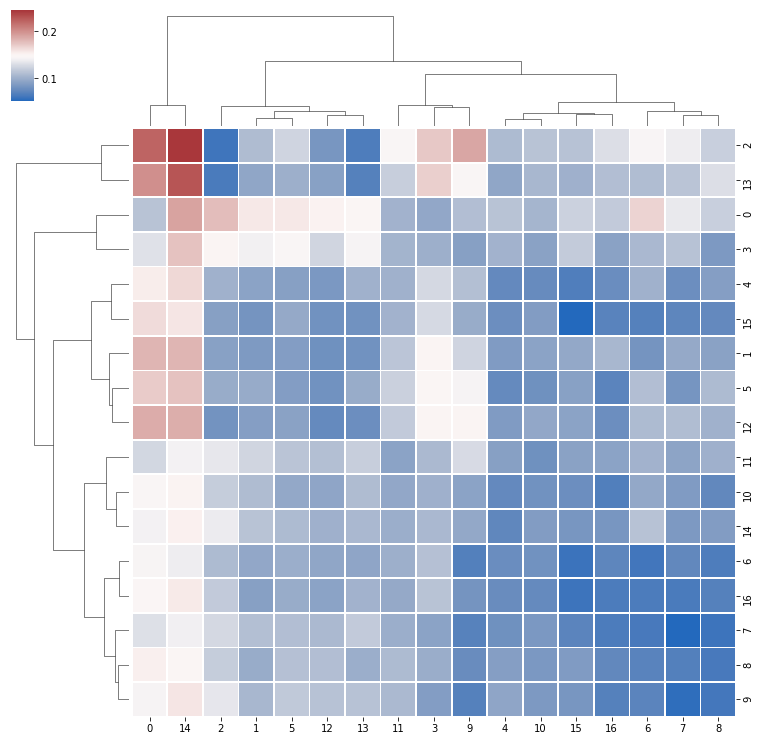

In [8]:
method = 'ward'
plot_dendogram(mat_mape_ms, 
               "../results/mape_score_ms.pdf",
               method, 
               [k/10 for k in range(11)],
               div=True)